# WAve Models (WAM) Usage Example
WAM wave models are most widely used wave models in the world. 
This notebook illustrates ways of using WAM models data via Planet OS Datahub API, including:
point and raster API options

API documentation is available at http://docs.planetos.com. If you have questions or comments, join the Planet OS  Slack community to chat with our development team. For general information on usage of IPython/Jupyter and Matplotlib, please refer to their corresponding documentation. https://ipython.org/ and http://matplotlib.org/
First, you have to define usable API endpoint, which consists of server name, dataset name, API key and query details. It is necessary to provide location details, for point API single point and raster API, four courners.

Also, please make sure you have downloaded all the python modules that are imported below. Note that this example is using Python 3

In [1]:
%matplotlib notebook
import urllib.request
import numpy as np
import simplejson as json
import pandas as pd
from netCDF4 import Dataset, date2num, num2date
import ipywidgets as widgets
from IPython.display import display, clear_output
import dateutil.parser
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import time
from po_data_process import get_data_from_raster_API,get_data_from_point_API,get_variables_from_detail_api,read_data_to_json,generate_raster_api_query,get_units
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [2]:
dataset_keys = ['cmc_gdwps_wave_model_global','dwd_wam_europe','dwd_wam_global',
                'cmems_medsea_wave_analysis_forecast_0042']
server = "http://api.planetos.com/v1/datasets/"

<font color='red'>Please put your datahub API key into a file called APIKEY and place it to the notebook folder or assign your API key directly to the variable API_key!</font>

In [3]:
API_key = open('APIKEY').readlines()[0].strip() #'<YOUR API KEY HERE>'

Change latitude and longitude to your desired location. Longitude/latitude west/east are for raster API example. 

In [4]:
latitude = 'Please add location for point data'
longitude = 'Please add location for point data'
longitude_west = 'Please add location for raster data'
longitude_east = 'Please add location for raster data'
latitude_south = 'Please add location for raster data'
latitude_north = 'Please add location for raster data'

If you don't want to choose location by yourself, default locations will be used.

In [16]:
default_point_api_loc = {'cmc_gdwps_wave_model_global':['39','-69'],'dwd_wam_europe':['56.3','17.8'],
                         'dwd_wam_global':['39','-69'],'cmems_medsea_wave_analysis_forecast_0042':['38.3','5.8']}
default_raster_api_loc = {'cmc_gdwps_wave_model_global':['36','39','-62','-70'],'dwd_wam_europe':['55.2','56.5','17.4','20.2'],
                          'dwd_wam_global':['36','39','-62','-70'],'cmems_medsea_wave_analysis_forecast_0042':['35.8','37.8','16.5','19.5']}

Making dropdown for WAM dataset keys, where you can choose WAM model you would like to use. Note that when using Europe/ North-Atlantic/ North-Pacific/ Mediterranean Sea data points have to be from that area!

In [17]:
droplist0 = list(dataset_keys)
selecter0 = widgets.Dropdown(
        options=droplist0,
        value=droplist0[0],
        description='Select dataset:',
        disabled=False,
        button_style='' 
    )

display(selecter0)


In [18]:
dataset_key = selecter0.value
if latitude.isdigit() == False or longitude.isdigit() == False:
    latitude = default_point_api_loc[dataset_key][0]
    longitude = default_point_api_loc[dataset_key][1]
if latitude_south.isdigit() == False or latitude_north.isdigit() == False or longitude_east.isdigit == False \
or longitude_west.isdigit() == False:
    latitude_south = default_raster_api_loc[dataset_key][0]
    latitude_north = default_raster_api_loc[dataset_key][1]
    longitude_east = default_raster_api_loc[dataset_key][2]
    longitude_west = default_raster_api_loc[dataset_key][3]

In [19]:
def get_sample_var_name(variables, selected_variable, selected_level):
    ## The human readable variable name is not the same as the compact one in API request
    for i in variables:

        if i['longName'] == selected_variable:
            var = i['name']
        elif i["longName"] == selected_variable + "@" + selected_level:
            var = i['name']    
    return var

## Point data API

By _point data_ we mean data that is given at a single point (or from single measurement device) at different timesteps. For WAM, this means selection of one single geographic point and getting data for one or more parameters. Note that you need to choose point which has coverage on that area. To follow the examples better, we suggest to pay attention to following API keywords, which may not seem obvious in first place:

1. count -- how many values for particular context (set of spatial and temporal dimensions) are returned
2. z -- selection of vertical levels (some variables have values on different heights)

In [20]:
point_data_frame = get_data_from_point_API(dataset_key,longitude,latitude,API_key)

http://api.planetos.com/v1/datasets/cmc_gdwps_wave_model_global/point?lat=39&lon=-69&apikey=8428878e4b944abeb84790e832c633fc&count=100000&z=all&verbose=False


Getting variables for choosen dataset

In [21]:
dataset_variables = get_variables_from_detail_api(server,dataset_key,API_key)
vardict = {}

levelset = []
for i in dataset_variables:
    if '@' in i['longName']:
        if not i['longName'].split("@")[1] in levelset:
            levelset.append(i['longName'].split("@")[1])
        varname, varlevel = i['longName'].split("@")
    else:
        if not 'Ground or water surface' in levelset:
            levelset.append('Ground or water surface')
        varname, varlevel = i['longName'], 'Ground or water surface'
       
        
    if not varlevel in vardict:
        vardict[varlevel] = []
        vardict[varlevel].append(varname)
    else:
        vardict[varlevel].append(varname)

Now let's plot the data. We are making two dropdown lists. From first you have to choose level type. It means that data is separated by contexts. Context here means just a set of spatial and temporal dimensions for particular variable, like NetCDF dimensions. Each variable has values only in one context. So the NaN's do not come from the API request, but from the current way we use to create the Dataframe. It is not difficult to filter out variables from the dataframe, but for any use case besides observing the data, it is more reasonable to query only the right data from the server.

http://api.planetos.com/v1/datasets/cmc_gdwps_wave_model_global/point?lat=39&lon=-69&apikey=8428878e4b944abeb84790e832c633fc&count=100000&z=all&verbose=False&var=v-component_of_wind_height_above_ground


<IPython.core.display.Javascript object>


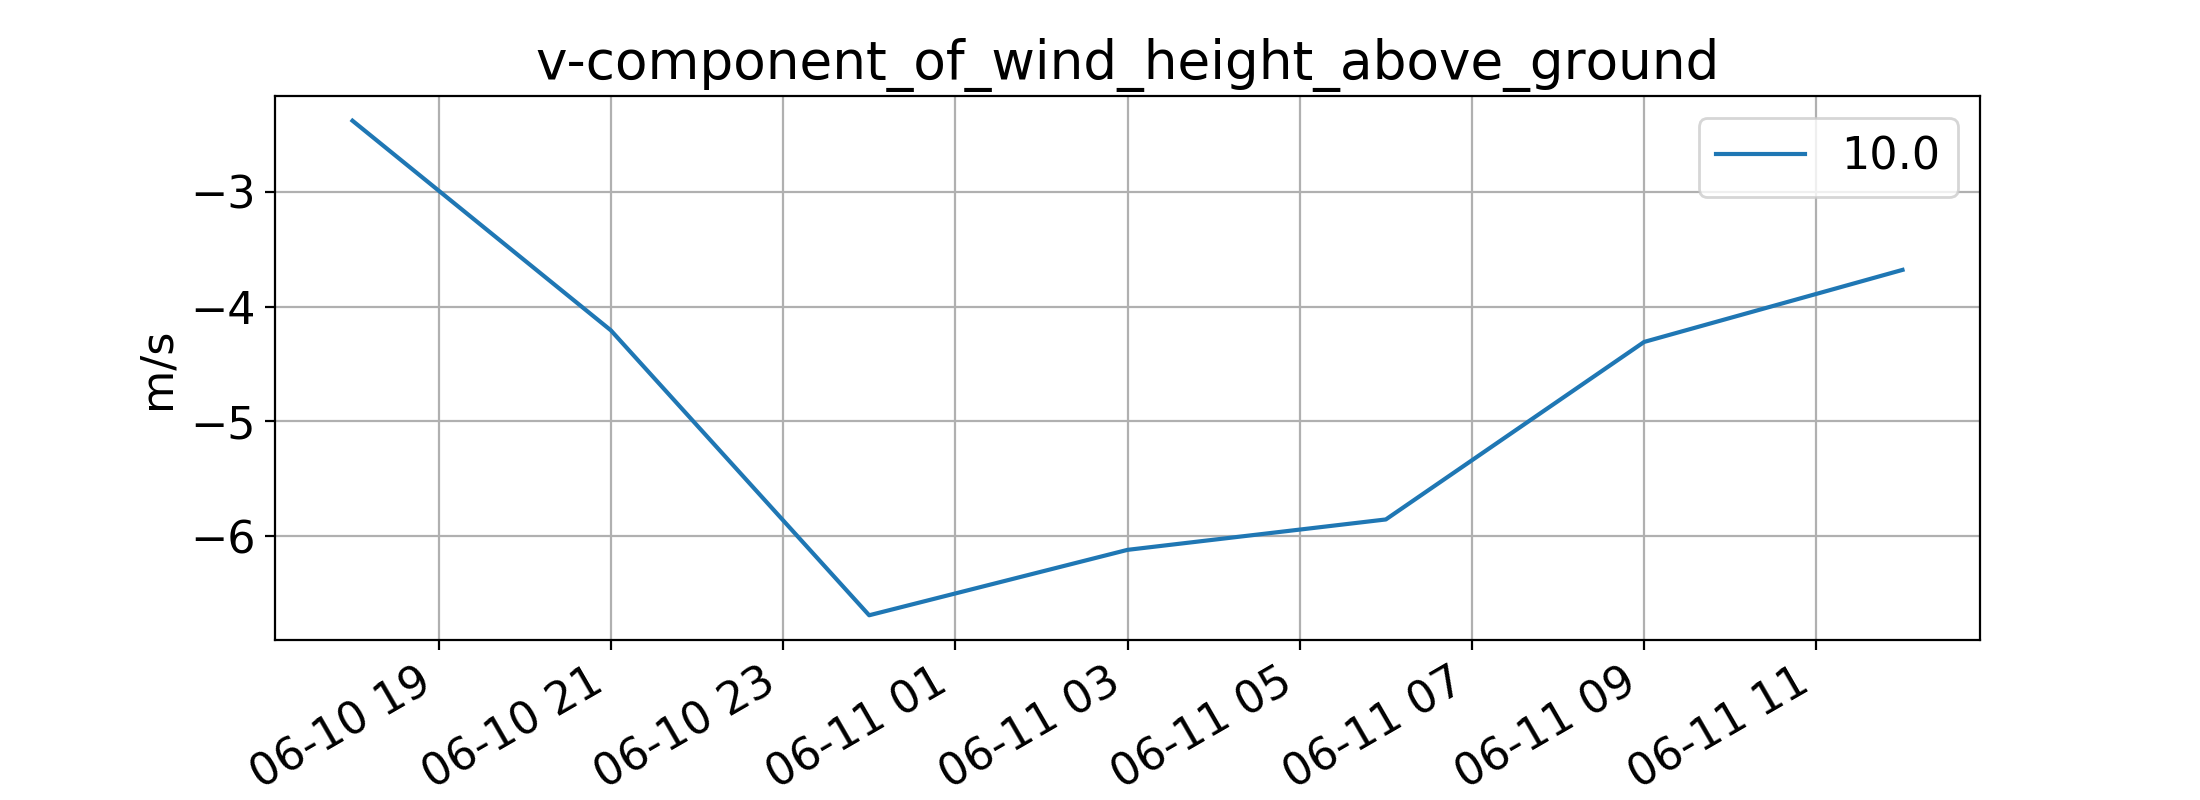

In [22]:
droplist = list(levelset)

selecter = widgets.Dropdown(
        options = droplist,
        value = droplist[0],
        description = 'Select level type:',
        disabled = False,
        button_style = '' 
    )
selecter2 = widgets.Dropdown(
        options = sorted(vardict[selecter.value]),
        value = vardict[selecter.value][0],
        description = 'Select variable:',
        disabled = False,
        button_style = ''
    )

def select_from_list2(sender):
    selecter2.options = vardict[selecter.value]
    
def plot_selected_variable(sender):
    clear_output()
    sample_var_name = get_sample_var_name(dataset_variables, selecter2.value, selecter.value)
    #sample_point_data_json = read_data_to_json(generate_point_api_query(**{'var':sample_var_name,'count':100000}))
    sample_point_data_pd = get_data_from_point_API(dataset_key,longitude,latitude,API_key,var=sample_var_name,count=100000)
    unit = get_units(dataset_key,sample_var_name,API_key)
    
    
    fig = plt.figure(figsize=(11,4))
    ## find how many vertical levels we have
    if 'z' in sample_point_data_pd:
        zlevels = sample_point_data_pd['z'].unique()
        if len(zlevels) != 1:
            print("Warning: more than one vertical level detected ", zlevels)
            
        for i in zlevels:
            pdata=np.array(sample_point_data_pd[sample_point_data_pd['z'] == i][sample_var_name],dtype=np.float)
            if np.sum(np.isnan(pdata)) != pdata.shape[0]:
                plt.plot(sample_point_data_pd[sample_point_data_pd['z'] == i]['time'].apply(dateutil.parser.parse),pdata,label=i)
            else:
                print("Cannot plot all empty values!")
    else:
        pdata = np.array(sample_point_data_pd[sample_var_name],dtype = np.float)
        if np.sum(np.isnan(pdata)) != pdata.shape[0]:
            plt.plot(sample_point_data_pd['time'].apply(dateutil.parser.parse), pdata, '*-', label=sample_var_name)      
        else:
            print("Cannot plot all empty values!")
    plt.legend()
    plt.grid()
    fig.autofmt_xdate()
    plt.xlabel('Date')
    plt.title(sample_var_name)
    plt.ylabel(unit)
    plt.show()

    
display(selecter)
display(selecter2)
    
selecter.observe(select_from_list2)
selecter2.observe(plot_selected_variable, names='value')


## Raster API

Now we are using raster API. Please note that the data size returned by raster API is limited, to keep the JSON string size reasonable. If you want to get larger data, please try our new asynchronous API to download NetCDF files: http://docs.planetos.com/?#bulk-data-packaging

In [23]:
sample_var_name = get_sample_var_name(dataset_variables, selecter2.value, selecter.value)
sample_raster_data = get_data_from_raster_API(dataset_key, longitude_west, latitude_south, 
                                                   longitude_east, latitude_north, API_key,var=sample_var_name,
                                                   count=1000)
data_min = np.amin([np.nanmin(np.array(i,dtype=float)) for i in sample_raster_data[sample_var_name]])
data_max = np.amax([np.nanmax(np.array(i,dtype=float)) for i in sample_raster_data[sample_var_name]])

Longitude and latitude data is necessary for map and it is defined at the beginning of the notebook by user.
Map projection can easily be changed by user as well.

In [24]:
raster_latitude = sample_raster_data['indexAxes'][0][0][1]
raster_longitude = sample_raster_data['indexAxes'][0][1][1]

m = Basemap(projection='merc',llcrnrlat=float(latitude_south),urcrnrlat=float(latitude_north),\
            llcrnrlon=float(longitude_west),urcrnrlon=float(longitude_east),lat_ts=(float(latitude_south)+float(latitude_north))/2,resolution='i')
lonmap, latmap = m(np.meshgrid(raster_longitude,raster_latitude)[0],np.meshgrid(raster_longitude, raster_latitude)[1])

Now let's map our data! 

In [25]:
def loadimg(k):
    unit = get_units(dataset_key,sample_var_name,API_key)
    fig=plt.figure(figsize=(7,5))
    data = np.ma.masked_invalid(np.array(sample_raster_data[sample_var_name][k],dtype=float))
    m.pcolormesh(lonmap,latmap,data,vmax=data_max,vmin=data_min)
    m.drawcoastlines()
    m.drawcountries()
    plt.title(selecter2.value + " " + sample_raster_data['time'][k],fontsize=10)
    cbar = plt.colorbar()
    
    cbar.set_label(unit)
    print("Maximum: ",np.nanmax(data))
    print("Minimum: ",np.nanmin(data))

    plt.show()
widgets.interact(loadimg, k=widgets.IntSlider(min=0,max=(len(sample_raster_data)-1),step=1,value=0, layout=widgets.Layout(width='100%')))

<function __main__.loadimg>

As time slider for image above does not work in GitHub preview, let's make image from last time moment. Although, it will work in your local environment. 

<IPython.core.display.Javascript object>


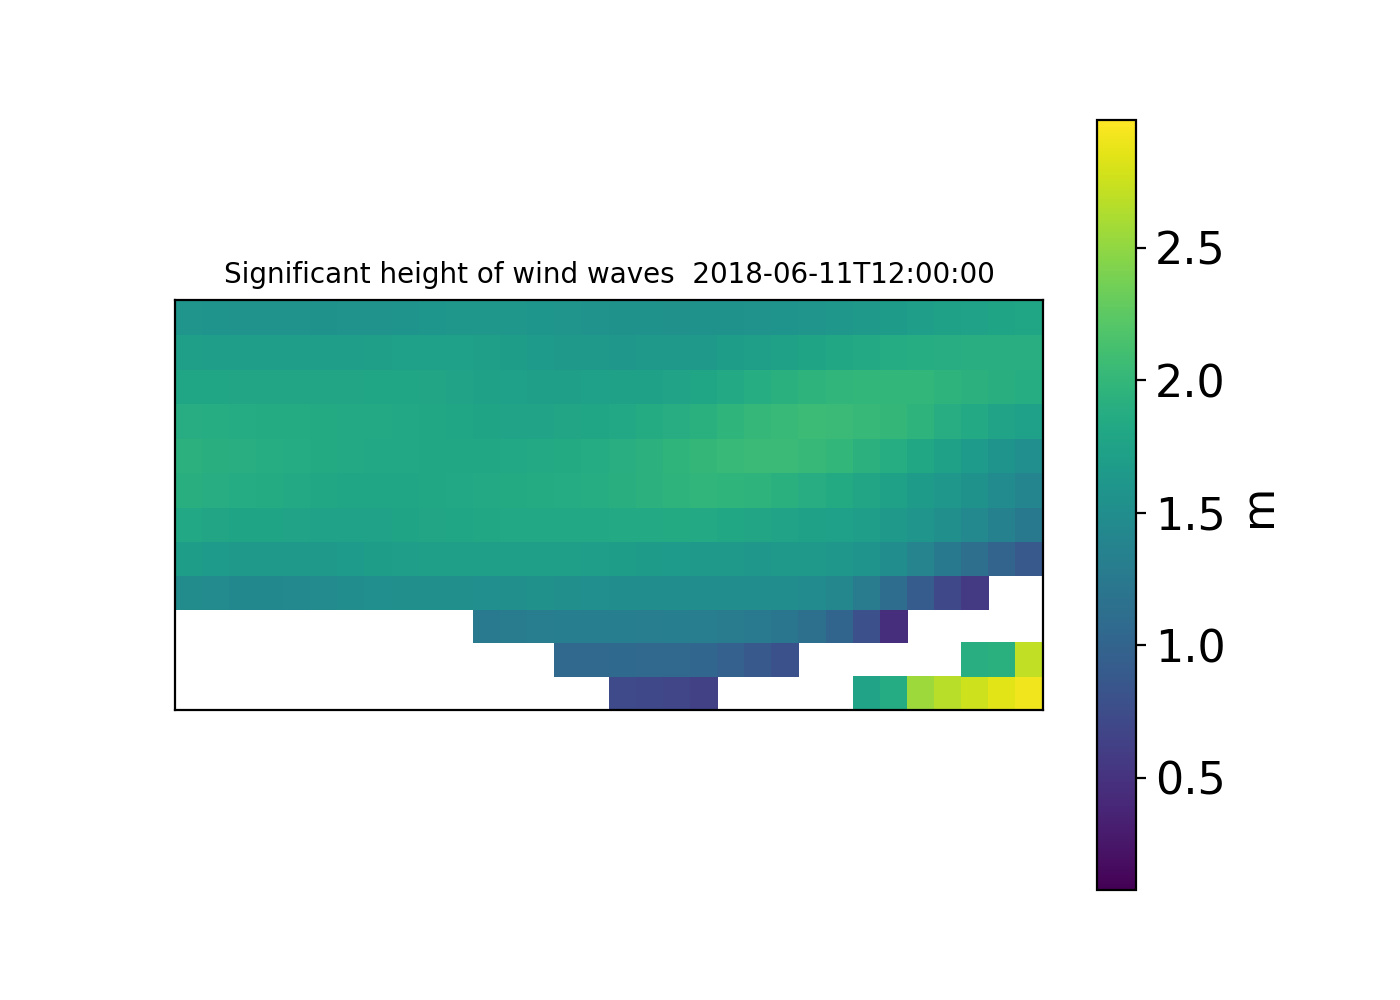

Maximum:  2.98310303688
Minimum:  0.173053056002


In [26]:
loadimg((len(sample_raster_data)-1))